In [1]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn import mixture
from sklearn.datasets import make_blobs
import os
import collections as coll
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import norm, multivariate_normal
import seaborn as sns
from numpy.linalg import inv
from statsmodels.graphics import tsaplots

from pdb import set_trace

In [2]:
os.getcwd()
#for i in os.listdir(): print(i)

def qnorm(p, mu=0, sd=1):
   return norm.ppf(p, loc=mu, scale=sd)

def pnorm(x, mu=0, sd=1):
   return norm.cdf(x, loc=mu, scale=sd)

#def pmvnorm(x, mu=0, sigma=1):
#   mvn = multivariate_normal(x, mean=mu, cov=sigma)
#   return mvn.cdf(x)
   

# Ordered probit 
See Lynch book for details

In [ ]:
# import some data to play with
iris = datasets.load_iris()
#X, y = datasets.load_digits(return_X_y=True)
#X = pd.DataFrame(X)

X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target


In [2]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=10)

coll.Counter(y)

X.shape

(1000, 10)

In [3]:
N, K = X.shape
M = len(set(y))           # number of bins
print(M)

MC = 3000

t = np.zeros(M+1)
b = np.zeros(K)
t_mc = np.zeros((M+1, MC))
b_mc = np.zeros((K, MC))
ystar_mc = np.zeros((N, MC))

vb = linalg.inv(np.dot(X.T,X))
ch_lower = linalg.cholesky(vb)

t[0] = -np.inf
t[1] = 0
t[2] = qnorm(np.sum(y <= 1)/N, mu = -qnorm(np.sum(y == 0)/N, 0,1), sd = 1)
t[3] = qnorm(np.sum(y <= 2)/N, mu = -qnorm(np.sum(y == 0)/N, 0,1), sd = 1)
t[4] = qnorm(np.sum(y <= 3)/N, mu = -qnorm(np.sum(y == 0)/N, 0,1), sd = 1)
t[M] = np.inf


5


In [67]:
#it = iter(range(MC))

In [68]:

for i in range(MC):

  xb = np.dot(X,b_mc[:,i])
  ystar = qnorm(np.random.uniform(low = pnorm(t[y], mu = xb, sd = 1), high = pnorm(t[y+1], mu = xb, sd = 1), size = N), mu = xb, sd = 1)
  ystar_mc[:,i] = ystar

  for k in range(2, len(t)-1, 1):
      t[k] = np.random.uniform(low = np.max(ystar[y == k-1]), high = np.min(ystar[y == k]), size = 1)
      t_mc[:,i] = t
      
  b = np.dot(vb,np.dot(X.T, ystar)) + np.dot(ch_lower, np.random.normal(loc = 0, scale=1, size=K))
  b_mc[:,i] = b
  
  if i % 100 == 0: 
      print('Iter. {} - betas {} - t {}'.format(i, b, t))

print("Finished!")

Iter. 0 - betas [-0.0652287  -0.06451497  0.03591203 -0.08228562 -0.03259536  0.05236459
 -0.11159004 -0.0578831  -0.02829518 -0.03811355] - t [      -inf 0.         0.58927419 1.09463366 1.68123288        inf]
Iter. 100 - betas [-0.05796202 -0.01978103  0.05925339 -0.11170915 -0.01257277  0.05300102
 -0.0637759  -0.11394467 -0.02657286 -0.03472892] - t [      -inf 0.         0.5471182  1.01629855 1.63848829        inf]
Iter. 200 - betas [-0.01513358 -0.01243585  0.05503901 -0.10747509 -0.0396406  -0.00064033
 -0.06450627 -0.09472761 -0.04336949  0.01608107] - t [      -inf 0.         0.48131945 0.96919651 1.56165445        inf]
Iter. 300 - betas [-0.02780677 -0.03468252  0.07920565 -0.09605651 -0.04361583  0.03391623
 -0.03729483 -0.05252007 -0.05394007 -0.02056084] - t [      -inf 0.         0.44097877 0.90192259 1.49142892        inf]
Iter. 400 - betas [-0.02186185 -0.06640185  0.05201247 -0.0912834  -0.05796973  0.03150351
 -0.06891035 -0.02767696 -0.05823242 -0.01775025] - t [    

In [69]:
t_mc
t_mean = np.mean(t_mc, axis=1)
t_mean.shape

(6,)

In [70]:
b_mean = np.mean(b_mc, axis=1)
b_mean.shape

(10,)

In [71]:
ystar_s2 = np.var(ystar_mc, axis=1)
ystar_mean = np.mean(ystar_mc, axis=1)

In [72]:
#ystar_mc[:,1000]

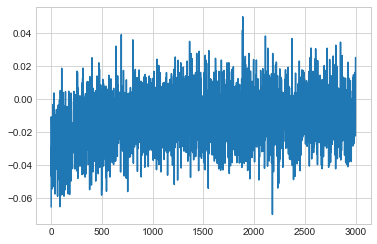

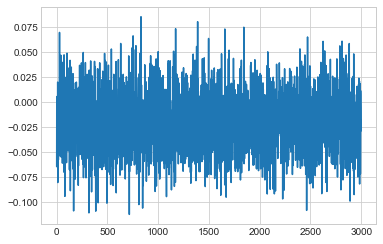

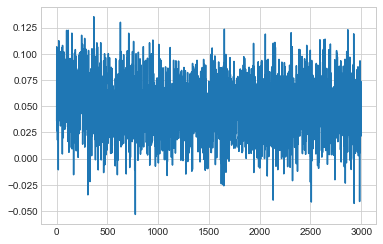

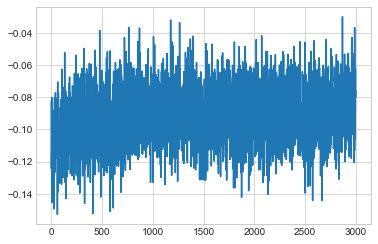

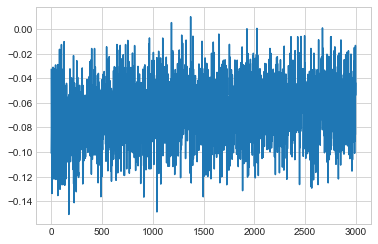

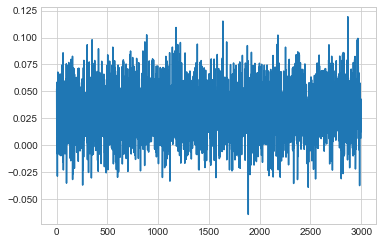

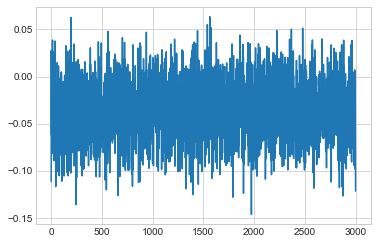

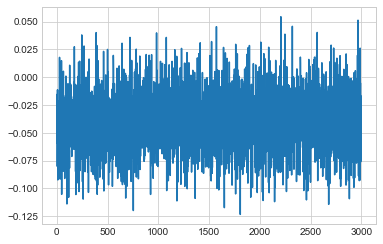

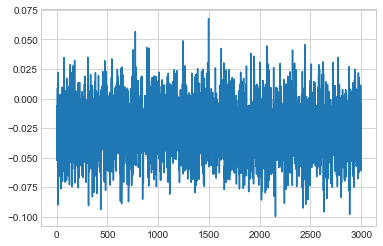

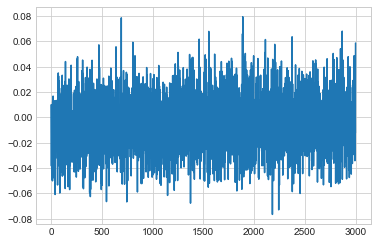

In [73]:
for col in range(b_mc.shape[0]):
    plt.plot(b_mc[col,:])
    plt.show()

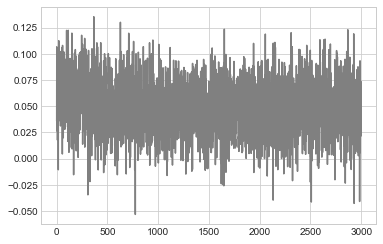

In [74]:
plt.plot(b_mc[2,:], c="gray")
plt.show()

In [75]:
t_mean

array([      -inf, 0.        , 0.3749285 , 0.76634386, 1.25946751,
              inf])

In [76]:
ystar_labels = [np.min(np.where(ystar_mean[n] <= t_mean)[0]) - 1 for n in range(N)] 

In [77]:
set(ystar_labels)

{0, 1, 2, 3, 4}

In [78]:
set(y)

{0, 1, 2, 3, 4}

In [79]:
sum(y != ystar_labels)

0

In [80]:
pd.DataFrame({'y':y, 'yhat': ystar_labels}).head()

,y,yhat
0,1,1
1,1,1
2,0,0
3,0,0
4,3,3


# Binary probit:
see also https://rstudio-pubs-static.s3.amazonaws.com/208180_b659633007eb45aa9c48e4c50b8afc07.html

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
#data.target[[10, 50, 85]]
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
def rtruncnorm(n, a = -np.inf, b = np.inf, mu = 0, sigma = 1): 
    """
    Draw from (double) truncated normal distribution

    Inputs:
    n : size, humber of random draws
    a, b : left, right truncation points
    mu, sigma : mean and standard deviation of normal distr.

    Output:
    Array with draws of length n 
    """
    assert b > a, 'Upper truncation point must be strictly greater than lower!'
    u = np.random.uniform(size=n)
    x = qnorm((1 - u)*pnorm((a - mu)/sigma) + u*pnorm((b - mu)/sigma))           # see Lynch for example
    return mu + sigma * x


In [7]:
draws = rtruncnorm(10000, a = -1, b = np.inf)

Text(0.5, 1.0, 'Truncated Normal distribution')

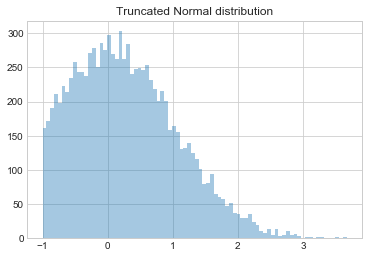

In [127]:
sns.distplot(draws, bins=80, kde=False, rug=False).set_title('Truncated Normal distribution')

## Simulate data

In [3]:

def simulate_DGP(N, D, mu_theta = 0, set_seed = None):
    """
    Draw from data generating process
    """
    if set_seed: 
        np.random.seed(set_seed)
    X = np.zeros((N,D+1))
    X[:,0] = 1                                         # constant
    X[:,1:] = np.random.random((N, D)) #* 2 - 1     # draw d-dim. uniform [-1, +1]
    #X[:,1:] = np.random.multivariate_normal(mean = np.zeros(D), cov = 1.1*np.eye(D), size = N)

    # True values of regression coeff. theta
    true_theta = np.random.normal(mu_theta, 1, D+1)
    #true_theta = np.random.random(D+1) * 2 - 1     # draw d+1-dim uniform [-1, +1]

    # Obtain the vector with probabilities of success p using the probit link
    p = pnorm(np.dot(X,true_theta))

    # Generate binary observation data y
    y = np.random.binomial(1, p, N) 
    return y, X, true_theta 


In [4]:
#X, y = make_blobs(n_samples=1000, centers=2, n_features=10)

N = 1000       # sample size
D = 5         # number of features

y, X, true_theta = simulate_DGP(N, D, set_seed = 42)

coll.Counter(y)

Counter({0: 781, 1: 219})

In [53]:
#pd.DataFrame(X).describe()

# Gibbs sampling algorithm

In [133]:
import pandas as pd
import numpy as np
from numpy import linalg
import os
from scipy.stats import norm
from numpy.linalg import inv
from statsmodels.graphics import tsaplots
from sklearn.base import BaseEstimator

def qnorm(p, mu=0, sd=1):
   return norm.ppf(p, loc=mu, scale=sd)

 
def pnorm(x, mu=0, sd=1):
   return norm.cdf(x, loc=mu, scale=sd)


class BayesProbitClassifier(BaseEstimator):
    """
    Bayesian Binary Probit regression using Gibbs sampling
    """
    def __init__(self, N_sim : int = 10000, burn_in : int = 5000, pred_mode : list = ['plug_in', 'full'], thin : int = None,  
                 seed : int = None, verbose : bool = True):

        self.N_sim = N_sim
        self.burn_in = burn_in
        self.seed = seed
        self.verbose = verbose
        self.thin = thin
        self.pred_mode = pred_mode[0]
        assert self.N_sim > self.burn_in, 'Set N_sim >> burn_in !!'

 
    def rtruncnorm(self, n, a = -np.inf, b = np.inf, mu = 0, sigma = 1):
        """
        Draw from (double) truncated normal distribution
        Inputs:
        n : size, humber of random draws
        a, b : left, right truncation points
        mu, sigma : mean and standard deviation of normal distr.

        Output:
        Array with draws of length n
        """
        assert b > a, 'Upper truncation point must be strictly greater than lower!'
        u = np.random.uniform(size=n)
        x = qnorm((1 - u)*pnorm((a - mu)/sigma) + u*pnorm((b - mu)/sigma))           # see Lynch for example
        return mu + sigma * x


    def fit(self, X, y):

        N, D = X.shape
        if self.seed is not None : np.random.seed(self.seed)

        # Conjugate prior on the coefficients \theta ~ N(theta_0, Q_0)
        theta_0 = np.zeros(D)
        Q_0 = np.diag([1]*D)

        # Initialize parameters
        theta = np.zeros(D)           
        z = np.zeros(N)
        self.theta_chain = np.zeros((self.N_sim, D))
        N1  = np.sum(y)  # Number of successes
        N0  = N - N1     # Number of failures
        mu_z = np.dot(X,theta)

        # Compute posterior variance of theta
        prec_0 = inv(Q_0)
        V = inv(prec_0 + np.dot(X.T, X))

        for t in range(1, self.N_sim):
            if (t % 1000 == 0) & self.verbose: print('Iter.{}'.format(t))

            # Update Mean of z
            mu_z = np.dot(X,theta.T)

            # Draw latent variable z from its full conditional: z | \theta, y, X
            z[y == 0] = self.rtruncnorm(N0, a = -np.inf, b = 0, mu = mu_z[y == 0].flatten(), sigma = 1)
            z[y == 1] = self.rtruncnorm(N1, a = 0, b = np.inf, mu = mu_z[y == 1].flatten(), sigma = 1)

            # Compute posterior mean of theta
            M = np.dot(V, np.dot(prec_0, theta_0) + np.dot(X.T, z))

            theta = np.random.multivariate_normal(mean = M, cov = V, size = 1)
            self.theta_chain[t, :] = theta

        #if self.verbose : print('Training finished!')   

        if self.thin is not None:
            if self.verbose : print('Apply {}-thinning.'.format(self.thin))
            index_thinning = np.array(range(self.theta_chain.shape[0]))
            self.theta_chain = self.theta_chain[index_thinning[index_thinning[0]::self.thin], :]    # take every thin'th value 

        self.theta_final = self.theta_chain[self.burn_in:,:]
        if self.verbose : print('Discarding first {} draws.'.format(self.burn_in))

        # Get posterior mean of \theta
        self.post_theta_est = np.mean(self.theta_final, axis=0)
        #self.post_theta_est = np.median(self.theta_final, axis=0)
        return self.post_theta_est                  # 'beta hats' 


    def score(self, X, y):
        """
        Calculate accuracy score.
        y: true labels associated with X
        """
        _, yhat = self.predict(X=X)
        self.accuracy = np.mean(y == yhat)
        #if self.verbose : print('Accuracy : {}'.format(self.accuracy))
        return self.accuracy
    

    def predict(self, X):

        N = X.shape[0]
        self.dec_thresh = 0.5
        print('Using predictive mode: {}'.format(self.pred_mode))
        self.p_pred_train = np.zeros((self.N_sim - self.burn_in, N))     # success posterior predictive prob.

        # Evaluate posterior predictive p.m.f.:
        #----------------------------------------
        if self.pred_mode == 'full':

            for j in range(self.theta_final.shape[0]):
                if (j % 1000 == 0) & self.verbose: print('Iter.{}'.format(j))
                self.p_pred_train[j,:] = pnorm(np.dot(X, self.theta_final[j,:].T)).flatten()                 # given X (training data!)

            # Draw from pred. distr.:
            #-------------------------
            #y_pred[t] = np.random.binomial(1, p_pred_train[:,t], N)
            pred_prob_estimate = np.mean(self.p_pred_train, axis=0)         # fully bayesian using the MCMC draws from the posterior
        else:        
            pred_prob_estimate = pnorm(np.dot(X, self.post_theta_est))        # plug-in estimate (see Robert/Marin)
        #if self.verbose : print('Prediction finished!')   
        yhat = (pred_prob_estimate > self.dec_thresh)*1.
        return pred_prob_estimate, yhat


In [134]:
bp = BayesProbitClassifier(N_sim = 5000, burn_in = 2000, pred_mode = ['full'])

In [135]:
fitted = bp.fit(X=X_train, y=y_train)

Iter.1000
Iter.2000
Iter.3000
Iter.4000
Discarding first 2000 draws.


In [136]:
#bp.post_theta_est

In [137]:
#phat_train, yhat_train = bp.predict(X_train)

In [138]:
bp.score(X_test, y_test)

Using predictive mode: full
Iter.0
Iter.1000
Iter.2000


0.6103030303030303

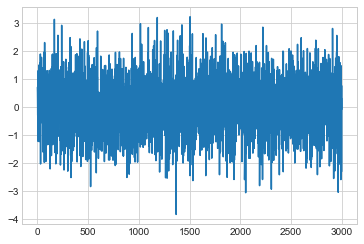

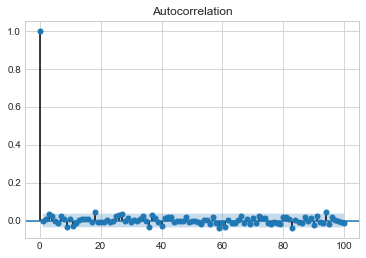

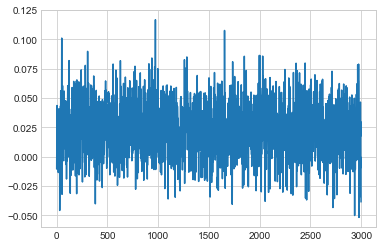

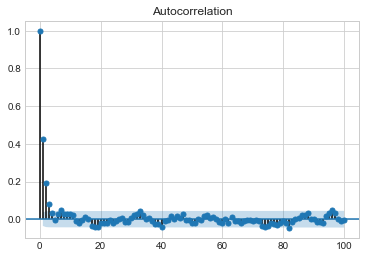

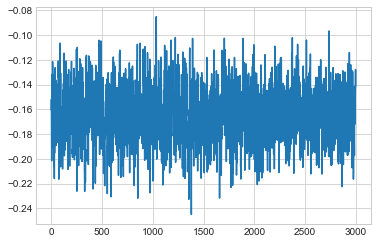

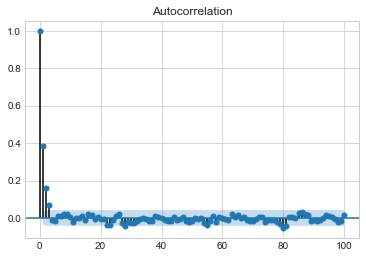

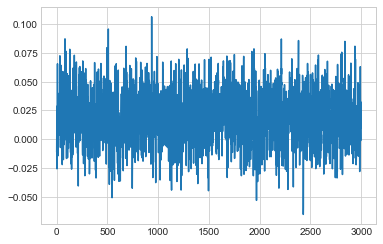

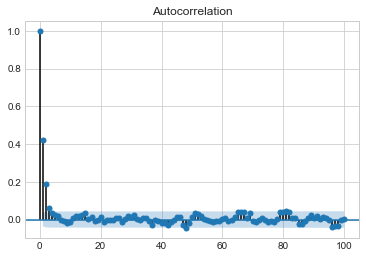

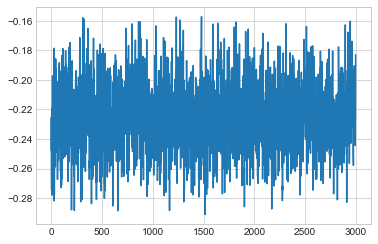

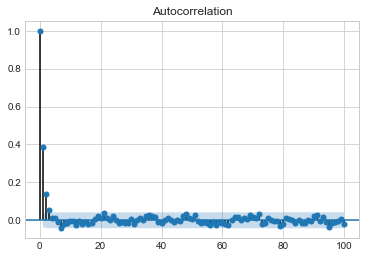

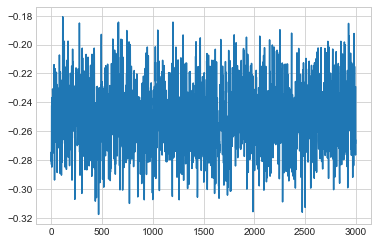

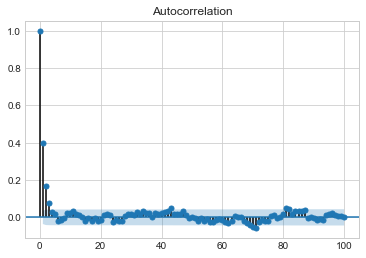

In [139]:
for col in range(bp.theta_final.shape[1]):
    plt.plot(bp.theta_final[:,col])
    fig = tsaplots.plot_acf(bp.theta_final[:,col], lags=100)
    plt.show()

Same as above but without class structure:

In [155]:

# Conjugate prior on the coefficients \theta ~ N(theta_0, Q_0)
theta_0 = np.zeros(D)
Q_0 = np.diag([1]*D)

# Initialize parameters
theta = np.zeros(D)            
z = np.zeros(N)

# Number of simulations for Gibbs sampler
N_sim = 1000 

# Burn in period
burn_in = 500

# Matrix storing samples of the \theta parameter
theta_chain = np.zeros((N_sim, D))
p_pred_train = np.zeros((N_sim, N))     # success posterior predictive prob.

# Variables that we will need later
N1  = np.sum(y)  # Number of successes
N0  = N - N1     # Number of failures


In [156]:
mu_z = np.dot(X,theta) 

# Compute posterior variance of theta
prec_0 = inv(Q_0)
V = inv(prec_0 + np.dot(X.T, X))

for t in range(1, N_sim):
    
    if t % 1000 == 0: print(t) 

    # Update Mean of z
    mu_z = np.dot(X,theta.T) 

    # Draw latent variable z from its full conditional: z | \theta, y, X
    z[y == 0] = rtruncnorm(N0, a = -np.inf, b = 0, mu = mu_z[y == 0].flatten(), sigma = 1) 
    z[y == 1] = rtruncnorm(N1, a = 0, b = np.inf, mu = mu_z[y == 1].flatten(), sigma = 1)

    # Compute posterior mean of theta
    M = np.dot(V, np.dot(prec_0, theta_0) + np.dot(X.T, z))

    theta = np.random.multivariate_normal(mean = M, cov = V, size = 1)
    theta_chain[t, :] = theta

    # Evaluate posterior predictive p.m.f.:
    #----------------------------------------
    p_pred_train[t,:] = pnorm(np.dot(X, theta.T)).flatten()                 # given X (training data!)

    # Draw from pred. distr.:
    #-------------------------
    #y_pred[t] = np.random.binomial(1, p_pred_train[:,t], N) 

print('\nDone!')    


Done!


In [157]:
#pnorm(np.dot(X, theta.T)).flatten()
#theta.shape

In [158]:
# ---------------------------
# Get posterior mean of \theta
# ---------------------------
post_theta = np.mean(theta_chain[burn_in:,:], axis=0)

In [159]:
#from statsmodels.discrete.discrete_model import Probit

#pr = Probit(endog = y, exog = X, missing = None)

#pfit = pr.fit()
#pr.predict()

In [160]:
post_theta

array([-0.44899931,  3.1459838 ])

In [161]:
true_theta

array([-0.5,  3.3])

In [162]:
p_pred_train_mc = np.mean(p_pred_train[burn_in:,:], axis=0)
p_pred_train_mc.shape

(400,)

In [180]:
p_pred_train_plugin = pnorm(np.dot(X, post_theta))        # plug-in estimate (see Robert/Marin)

p_pred_train_plugin.shape

(400,)

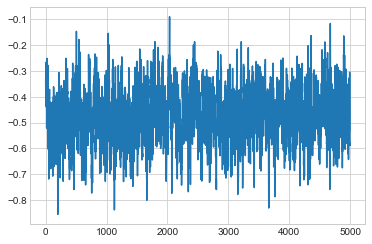

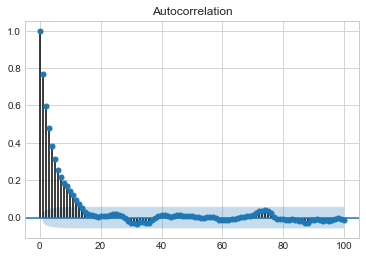

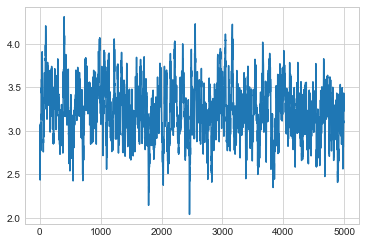

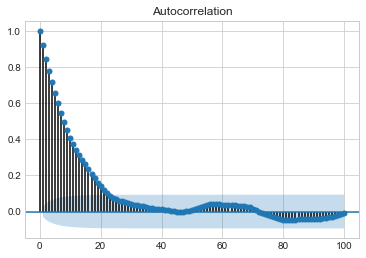

In [181]:
for col in range(theta_chain[burn_in:,:].shape[1]):
    plt.plot(theta_chain[burn_in:,col])
    fig = tsaplots.plot_acf(theta_chain[burn_in:,col], lags=100)
    plt.show()

# Variational inference Binary Probit

see https://rpubs.com/cakapourani/variational-bayes-bpr

In [2]:
from copy import deepcopy 
from math import pi, lgamma
from scipy.special import digamma
from numpy.linalg import det

In [3]:
N = 10000       # sample size
D = 20         # number of features

y, X, true_theta = simulate_DGP(N, D, set_seed = None)

coll.Counter(y)

NameError: name 'simulate_DGP' is not defined

In [188]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = load_breast_cancer()

X = data.data
y = data.target


### Create design matrix:

In [189]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin


class design_matrix(BaseEstimator, TransformerMixin):

    """
    Create design matrix based on a given basis function
    """
    
    def __init__(self, n_features, basis = ['poly', 'gauss'], add_bias = True, **basis_para):
        self.basis = basis[0]
        self.n_features = n_features
        self.add_bias = add_bias

        if self.basis == 'poly':
            self.meth = PolynomialFeatures(degree = self.n_features, include_bias=False, **basis_para)    # polynomial basis
        if self.basis == 'gauss':
            self.meth = GaussianFeatures(N = self.n_features, **basis_para)     # Gaussian basis function

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for i in range(X.shape[1]):
            self.meth.fit(X[:,i].reshape(-1,1))
            XX = self.meth.transform(X[:,i].reshape(-1,1))
            if i==0:
                A = XX
            else:
                A = np.concatenate((A,XX), axis=1)    
        if self.add_bias:
            A = np.insert(A, 0, values=1, axis=1)  # add 1 at colum 0      
        return A        

    def fit_transform(self, X, y=None):    
        return self.transform(X)
        

class GaussianFeatures(BaseEstimator, TransformerMixin):

    """Uniformly spaced Gaussian features for one-dimensional input"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,self.width_, axis=1)

#gauss_model = make_pipeline(GaussianFeatures(20),
#                            LinearRegression())

#gauss_model.fit(x[:, np.newaxis], y)
#yfit = gauss_model.predict(xfit[:, np.newaxis])


In [190]:
dm = design_matrix(n_features = 2, basis = ['gauss'], add_bias = False)

x = np.array([[2, 3, 4], [1, 0, 40]]).T
print(x.shape)

(3, 2)


In [191]:
X = dm.fit_transform(X)
X.shape

(569, 60)

Split the data:

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)


(381, 60)
(188, 60)


In [179]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

yhat_train = clf.predict(X_train)
yhat_test = clf.predict(X_test)

In [105]:
#def rbf_1d(xx, cc, hh):
#    return np.exp(-(xx-cc)**2 / hh**2)

# rbf_1d = lambda xx, cc, hh: np.exp(-(xx-cc)**2 / hh**2)
#plt.clf(); #plt.hold('on')
#grid_size = 0.01
#x_grid = np.arange(-10, 10, grid_size)
#plt.plot(x_grid, rbf_1d(x_grid, cc=5, hh=1), '-b')
#plt.plot(x_grid, rbf_1d(x_grid, cc=-2, hh=2), '-r')
#plt.show() 

In [124]:
#basis=None
#alpha_0 = 1e-1
#beta_0 = 1e-1 
#max_iter = 500
#epsilon_conv = .01 
#is_verbose = True
#from pdb import set_trace

In [136]:

def vbpr_fit(X, y, basis=None, alpha_0=1e-1, beta_0=1e-1, max_iter=500, epsilon_conv=1e-5, verbose=True):
    """
    Train binary probit model via Coordinate ascent mean-field variational inference (CAVI)
    Input:
    alpha_0, beta_0 : shape hyperparameters of Gamma prior of precision of conjugate zero-mean normal prior of regression coeff. w
    basis: matrix \Omega(x) with basis functions applied to each column of design matrix X 
    """
    N, D = X.shape
    L = np.full(max_iter, 0.)   # Store the lower bounds
    E_z = np.zeros(N)

    XX = np.dot(X.T, X)        # precalculate inner product
    alpha = alpha_0 + 0.5*D    # 'shape' of Gamma(\tau | \alpha, \beta)
    beta  = beta_0             # rate' of Gamma(\tau | \alpha, \beta)
    S = np.linalg.inv(np.eye(D) + XX)   # covariance of q(w | m, S)
    m =  np.zeros((D,1))             # mean of q(w | m, S)
    L[0] = -1e40                     # initialize lower bound (will be maximized!)
    robustify = 1e-10                # add small number to guarantee finite log values  

    # Iterate to find optimal parameters
    for i in range(1,max_iter):

        # Update mean of q(z)
        mu = np.dot(X, m) 
        mu_1 = mu[y == 1]  # Keep data where y == 1
        mu_0 = mu[y == 0]  # Keep data where y == 0

        # Compute expectation E[z]
        E_z[y == 1] = (mu_1 + norm.pdf(-mu_1)/(1 - pnorm(-mu_1))).squeeze()
        E_z[y == 0] = (mu_0 - norm.pdf(-mu_0) / pnorm(-mu_0)).squeeze()

        # Update parameters of q(w)
        S = np.linalg.inv((alpha/beta)*np.eye(D) + XX)         # posterior covariance of q(w)
        m = np.dot(S, np.dot(X.T, E_z)).reshape(D,1)            # posterior mean of q(w)

        beta = beta_0 + 0.5 * (np.dot(m.T, m) + np.trace(S))

        #-----------------------
        # Compute lower bound L:
        #-----------------------
        lb_p_zw_qw = -0.5*np.trace(np.dot(XX, np.dot(m, m.T) + S)) + 0.5*np.dot(mu.T, mu) + np.sum(y*np.log(1 - pnorm(-mu) + robustify).squeeze() + (1 - y)*np.log(pnorm(-mu) + robustify).squeeze())

        lb_pw = -0.5*D*np.log(2*pi) + 0.5*D*(digamma(alpha) - np.log(beta)) - alpha/(2*beta)*( np.dot(m.T, m) + np.trace(S) )

        lb_qw = -0.5*np.log(det(S)) -0.5*D*(1 + np.log(2*pi))

        lb_pa = alpha_0*np.log(beta_0) + (alpha_0 - 1)*(digamma(alpha) - np.log(beta)) - beta_0*(alpha/beta) - lgamma(alpha_0)

        lb_qa = -lgamma(alpha) + (alpha - 1)*digamma(alpha) + np.log(beta) - alpha

        L[i] = lb_p_zw_qw + lb_pw + lb_pa - lb_qw - lb_qa
 
        # Show VB difference
        if verbose & (i % 10 == 0): print('Iter. {} Lower Bound {} Delta LB {}\n'.format(i, L[i], L[i]-L[i - 1] ))

        # Check if lower bound decreases
        if L[i] < L[i - 1] : print("Lower bound decreases!\n")    

        # Check for convergence
        if L[i] - L[i - 1] < epsilon_conv : print("Converged!\n") ; break

        # Check if VB converged in the given maximum iterations
        if i == (max_iter-1) : print("VB did not converge!\n")

    return dict(m = m, S = S, alpha = alpha, beta = beta, LowerB = L[2:i])


def vbpr_predictive(X : np.array, model : dict):
    """
    Compute variational predictive distribution of the probit model
    """
    # Predictive mean
    mu_pred = (X @ model['m']).squeeze()
    # Predictive variance
    s_pred = np.sqrt(1 + np.diag( X @ model['S'] @ X.T ))
    #L = np.linalg.cholesky(s_pred)                                  
    # Bernoulli variational posterior predictive mass function:
    #Phi = pnorm(x = np.linalg.inv(L) @ mu_pred.squeeze())
    Phi = pnorm(x = np.divide(mu_pred, s_pred))
    return dict(Phi = Phi, mu_pred = mu_pred, s_pred = s_pred, yhat = (Phi>.5)*1.)




In [137]:
my_basis = deepcopy(X_train)

# Train:
model = vbpr_fit(X_train, y_train, basis=my_basis, alpha_0=1e-1, beta_0=1e-1, max_iter=500, verbose=True)


ta LB 0.026002309073476226

Iter. 222 Lower Bound -75.19229690387742 Delta LB 0.025739745923161195

Iter. 223 Lower Bound -75.16681641565721 Delta LB 0.025480488220210873

Iter. 224 Lower Bound -75.1415919334156 Delta LB 0.025224482241611668

Iter. 225 Lower Bound -75.11662025789873 Delta LB 0.0249716755168663

Iter. 226 Lower Bound -75.09189824145075 Delta LB 0.024722016447981332

Iter. 227 Lower Bound -75.06742278622013 Delta LB 0.024475455230614784

Iter. 228 Lower Bound -75.043190844561 Delta LB 0.024231941659138556

Iter. 229 Lower Bound -75.01919941640537 Delta LB 0.023991428155625272

Iter. 230 Lower Bound -74.9954455494028 Delta LB 0.02375386700256854

Iter. 231 Lower Bound -74.97192633762802 Delta LB 0.02351921177478289

Iter. 232 Lower Bound -74.94863892050878 Delta LB 0.023287417119234988

Iter. 233 Lower Bound -74.92558048272427 Delta LB 0.02305843778451333

Iter. 234 Lower Bound -74.90274825155342 Delta LB 0.022832231170852424

Iter. 235 Lower Bound -74.88013949809769 Delt

## Check lower bound for convergence:

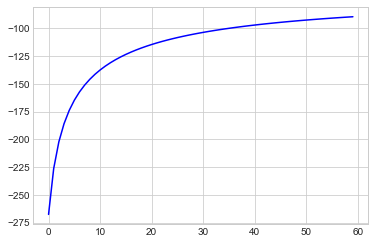

In [138]:
lower = model['LowerB'][model['LowerB'] != 0.]
x_grid = np.arange(len(lower))
trim = 60
trim = min(trim,len(lower)-1)

plt.clf()
plt.plot(x_grid[:trim], lower[:trim], '-b')
plt.show() 

In [91]:
model['m'].squeeze()

array([-0.18321426, -0.22182072, -0.17958496, -0.24276256, -0.05795989,
        0.19729516, -0.3616066 , -0.46138018,  0.0249761 ,  0.07004755,
       -0.51597055,  0.02820216, -0.36354743, -0.39274364, -0.10120764,
        0.24587219,  0.06003116, -0.10012263,  0.14314903,  0.22349531,
       -0.35770545, -0.4785969 , -0.30656121, -0.37936384, -0.26256305,
       -0.02559195, -0.37606417, -0.34296964, -0.43820751, -0.08946645])

In [92]:
true_theta

array([-1.06187946, -1.53879804, -0.79111027, -1.37950051,  0.6485723 ,
       -1.09461528,  0.52063148,  0.84277496,  0.61035221,  1.06193141,
        0.48668797, -0.28268927,  0.43335264,  0.19853452, -1.30256831,
       -1.4090558 , -0.47061229,  1.854128  ,  0.84157821, -1.42646315,
        1.17745151])

In [139]:
pred_out_train = vbpr_predictive(X_train, model)
pred_out_test = vbpr_predictive(X_test, model)

In [140]:
#y_pred = np.random.binomial(1, pred_out['Phi'], len(pred_out['Phi']))

In [141]:
#pd.DataFrame(pred_out['Phi']).hist(bins=50)

In [142]:
print(np.mean(pred_out_train['yhat'] == y_train))
print(np.mean(pred_out_test['yhat'] == y_test))

0.9868766404199475
0.9840425531914894


In [143]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9868766404199475
0.9787234042553191


In [173]:
from sklearn.base import BaseEstimator
from copy import deepcopy 
from math import pi, lgamma
from scipy.special import digamma
from numpy.linalg import det
import pandas as pd
import numpy as np
from numpy import linalg
import os
from scipy.stats import norm
from numpy.linalg import inv
from statsmodels.graphics import tsaplots


In [174]:

class BayesProbit(BaseEstimator):
    """
    Variational + MCMC Bayesian Binary Probit model inference
    """
    def __init__(self,  seed : int = None, verbose : bool = True):
        self.seed = seed
        self.verbose = verbose

    #def __del__(self): 
    #    print("Destructor called")

    def fit(self, X, y):    
        return self

    def predict(self, X):
        return self

    def score(self, X, y):
        return self

    def qnorm(self, p, mu=0, sd=1):
        return norm.ppf(p, loc=mu, scale=sd)

    def pnorm(self, x, mu=0, sd=1):
        return norm.cdf(x, loc=mu, scale=sd)

    def entropy(self, p0, p1):
    	return -(p0 * np.log2(p0) + p1 * np.log2(p1))    

    def rtruncnorm(self, n, a = -np.inf, b = np.inf, mu = 0, sigma = 1):
        """
        Draw from (double) truncated normal distribution
        Inputs:
        n : size, humber of random draws
        a, b : left, right truncation points
        mu, sigma : mean and standard deviation of normal distr.

        Output:
        Array with draws of length n
        """
        assert b > a, 'Upper truncation point must be strictly greater than lower!'
        u = np.random.uniform(size=n)
        x = self.qnorm((1 - u)*self.pnorm((a - mu)/sigma) + u*self.pnorm((b - mu)/sigma))           # see Lynch for example
        return mu + sigma * x


In [175]:

class BayesProbitClassifier_VI(BayesProbit):
    """
    Variational Bayesian Binary Probit model using coordinate ascent
    """
    def __init__(self, basis=None, seed : int = None, alpha_0=1e-1, beta_0=1e-1, max_iter=500, epsilon_conv=1e-5, verbose : bool = True):

        self.seed = seed
        self.verbose = verbose
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.max_iter = max_iter
        self.epsilon_conv = epsilon_conv
        super().__init__(self.seed, self.verbose)

    #def fit(self, X, y):    
    #    self.model = self.vbpr_fit(X, y)
    #    return self.model

    def predict(self, X):
        return (self.predict_proba(X) > .5)*1.

    #def predict_proba(self, X):
    #    self.pred_out = self.vbpr_predictive(X, self.model)
    #    return self.pred_out['prob']

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def fit(self, X, y):
        """
        Train binary probit model via Coordinate ascent mean-field variational inference (CAVI)
        Input:
        alpha_0, beta_0 : shape hyperparameters of Gamma prior of precision of conjugate zero-mean normal prior of regression coeff. w
        basis: matrix \Omega(x) with basis functions applied to each column of design matrix X 
        """
        N, D = X.shape
        L = np.full(self.max_iter, 0.)   # Store the lower bounds
        E_z = np.zeros(N)

        XX = np.dot(X.T, X)             # precalculate inner product
        alpha = self.alpha_0 + 0.5*D    # 'shape' of Gamma(\tau | \alpha, \beta)
        beta  = self.beta_0             # rate' of Gamma(\tau | \alpha, \beta)
        S = np.linalg.inv(np.eye(D) + XX)   # covariance of q(w | m, S)
        m =  np.zeros((D,1))             # mean of q(w | m, S)
        L[0] = -1e40                     # initialize lower bound (will be maximized!)
        robustify = 1e-10                # add small number to guarantee finite log values  

        # Iterate to find optimal parameters
        for i in range(1,self.max_iter):

            # Update mean of q(z)
            mu = np.dot(X, m) 
            mu_1 = mu[y == 1]  # Keep data where y == 1
            mu_0 = mu[y == 0]  # Keep data where y == 0

            # Compute expectation E[z]
            E_z[y == 1] = (mu_1 + norm.pdf(-mu_1)/(1 - self.pnorm(-mu_1))).squeeze()
            E_z[y == 0] = (mu_0 - norm.pdf(-mu_0) / self.pnorm(-mu_0)).squeeze()

            # Update parameters of q(w)
            S = np.linalg.inv((alpha/beta)*np.eye(D) + XX)         # posterior covariance of q(w)
            m = np.dot(S, np.dot(X.T, E_z)).reshape(D,1)            # posterior mean of q(w)
            beta = self.beta_0 + 0.5 * (np.dot(m.T, m) + np.trace(S))

            #-----------------------
            # Compute lower bound L:
            #-----------------------
            lb_p_zw_qw = -0.5*np.trace(np.dot(XX, np.dot(m, m.T) + S)) + 0.5*np.dot(mu.T, mu) + np.sum(y*np.log(1 - self.pnorm(-mu) + robustify).squeeze() + (1 - y)*np.log(self.pnorm(-mu) + robustify).squeeze())

            lb_pw = -0.5*D*np.log(2*pi) + 0.5*D*(digamma(alpha) - np.log(beta)) - alpha/(2*beta)*( np.dot(m.T, m) + np.trace(S))

            lb_qw = -0.5*np.log(det(S)) -0.5*D*(1 + np.log(2*pi))

            lb_pa = self.alpha_0*np.log(self.beta_0) + (self.alpha_0 - 1)*(digamma(alpha) - np.log(beta)) - self.beta_0*(alpha/beta) - lgamma(self.alpha_0)

            lb_qa = -lgamma(alpha) + (alpha - 1)*digamma(alpha) + np.log(beta) - alpha

            L[i] = lb_p_zw_qw + lb_pw + lb_pa - lb_qw - lb_qa
    
            # Show VB difference
            if self.verbose & (i % 10 == 0): print('Iter. {} Lower Bound {} Delta LB {}\n'.format(i, L[i], L[i]-L[i - 1] ))
            # Check if lower bound decreases
            if L[i] < L[i - 1] : print("Lower bound decreases!\n")    
            # Check for convergence
            if L[i] - L[i - 1] < self.epsilon_conv : print("Converged!\n") ; break
            # Check if VB converged in the given maximum iterations
            if i == (self.max_iter-1) : print("Algorithm did not converge!\n")

        self.model = dict(m = m, S = S, alpha = alpha, beta = beta, LowerB = L[2:i])
        return self.model


    def predict_proba(self, X : np.array):
        """
        Compute variational predictive distribution of the probit model
        """
        # Predictive mean
        self.mu_pred = (X @ self.model['m']).squeeze()
        # Predictive variance
        self.s_pred = np.sqrt(1 + np.diag( X @ self.model['S'] @ X.T ))
        # Bernoulli variational posterior predictive mass function:
        Phi = self.pnorm(x = np.divide(self.mu_pred, self.s_pred))                 # prob. of success
        return Phi


In [193]:
bp = BayesProbitClassifier_VI(alpha_0=1e-1, beta_0=1e-1, max_iter=500, verbose=False)

In [194]:
model = bp.fit(X_train, y_train)

Algorithm did not converge!



In [195]:
#bp.score(X_train, y_train)
bp.score(X_test, y_test)

0.9893617021276596

In [196]:
pprob = bp.predict_proba(X_test)

In [14]:
#bp.predict(X_test)

In [16]:
uncert = bp.entropy(p0 = 1-pprob, p1 = pprob)

pd.DataFrame({'Phi' : pprob,'Entropy' : uncert}).head()

,Phi,Entropy
0,7.845277e-01,0.751814
1,2.209057e-07,0.000005
2,4.638092e-03,0.042631
3,9.983703e-01,0.017443
4,9.999587e-01,0.000661


In [17]:

class BayesProbitClassifier_MCMC(BayesProbit):
    """
    Bayesian Binary Probit regression using Gibbs sampling
    """
    def __init__(self, N_sim : int = 10000, burn_in : int = 5000, pred_mode : list = ['plug_in', 'full'], thin : int = None,  
                 seed : int = None, verbose : bool = True):

        self.N_sim = N_sim
        self.burn_in = burn_in
        self.seed = seed
        self.verbose = verbose
        self.thin = thin
        self.pred_mode = pred_mode[0]
        super().__init__(self.seed, self.verbose)
        assert self.N_sim > self.burn_in, 'Set N_sim >> burn_in !!'


    def fit(self, X, y):

        N, D = X.shape
        if self.seed is not None : np.random.seed(self.seed)

        # Conjugate prior on the coefficients \theta ~ N(theta_0, Q_0)
        theta_0 = np.zeros(D)
        Q_0 = np.diag([1]*D)

        # Initialize parameters
        theta = np.zeros(D)           
        z = np.zeros(N)
        self.theta_chain = np.zeros((self.N_sim, D))
        N1  = np.sum(y)  # Number of successes
        N0  = N - N1     # Number of failures
        mu_z = np.dot(X,theta)

        # Compute posterior variance of theta
        prec_0 = inv(Q_0)
        V = inv(prec_0 + np.dot(X.T, X))

        for t in range(1, self.N_sim):
            if (t % 1000 == 0) & self.verbose: print('Iter.{}'.format(t))

            # Update Mean of z
            mu_z = np.dot(X,theta.T)

            # Draw latent variable z from its full conditional: z | \theta, y, X
            z[y == 0] = self.rtruncnorm(N0, a = -np.inf, b = 0, mu = mu_z[y == 0].flatten(), sigma = 1)
            z[y == 1] = self.rtruncnorm(N1, a = 0, b = np.inf, mu = mu_z[y == 1].flatten(), sigma = 1)

            # Compute posterior mean of theta
            M = np.dot(V, np.dot(prec_0, theta_0) + np.dot(X.T, z))

            theta = np.random.multivariate_normal(mean = M, cov = V, size = 1)
            self.theta_chain[t, :] = theta

        #if self.verbose : print('Training finished!')   

        if self.thin is not None:
            if self.verbose : print('Apply {}-thinning.'.format(self.thin))
            index_thinning = np.array(range(self.theta_chain.shape[0]))
            self.theta_chain = self.theta_chain[index_thinning[index_thinning[0]::self.thin], :]    # take every thin'th value 

        self.theta_final = self.theta_chain[self.burn_in:,:]
        if self.verbose : print('Discarding first {} draws.'.format(self.burn_in))

        # Get posterior mean of \theta
        self.post_theta_est = np.mean(self.theta_final, axis=0)
        #self.post_theta_est = np.median(self.theta_final, axis=0)
        return self.post_theta_est                  # 'beta hats' 


    def score(self, X, y):
        """
        Calculate accuracy score.
        y: true labels associated with X
        """
        yhat = self.predict(X=X)
        self.accuracy = np.mean(y == yhat)
        #if self.verbose : print('Accuracy : {}'.format(self.accuracy))
        return self.accuracy
    

    def predict_proba(self, X):

        N = X.shape[0]
        self.dec_thresh = 0.5
        print('Using predictive mode: {}'.format(self.pred_mode))
        self.p_pred_train = np.zeros((self.N_sim - self.burn_in, N))     # success posterior predictive prob.

        # Evaluate posterior predictive p.m.f.:
        #----------------------------------------
        if self.pred_mode == 'full':

            for j in range(self.theta_final.shape[0]):
                if (j % 1000 == 0) & self.verbose: print('Iter.{}'.format(j))
                self.p_pred_train[j,:] = self.pnorm(np.dot(X, self.theta_final[j,:].T)).flatten()                 # given X (training data!)

            # Draw from pred. distr.:
            #-------------------------
            #y_pred[t] = np.random.binomial(1, p_pred_train[:,t], N)
            pred_prob_estimate = np.mean(self.p_pred_train, axis=0)         # fully bayesian using the MCMC draws from the posterior
        else:        
            pred_prob_estimate = self.pnorm(np.dot(X, self.post_theta_est))        # plug-in estimate (see Robert/Marin)
        #if self.verbose : print('Prediction finished!')   
        return pred_prob_estimate


    def predict(self, X):
        return (self.predict_proba(X) > self.dec_thresh)*1.


In [18]:
bp = BayesProbitClassifier_MCMC(N_sim = 5000, burn_in = 2000, verbose=False)

In [19]:
model = bp.fit(X_train, y_train)

In [20]:
bp.score(X_test, y_test)

Using predictive mode: plug_in


0.9840425531914894

In [21]:
#bp.predict(X_train)

In [22]:
#bp.predict_proba(X_train)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])

poly = PolynomialFeatures(3, include_bias=False)

poly.fit_transform(x[:, None])

 

from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7),

                           LinearRegression())

rng = np.random.RandomState(1)

x = 10 * rng.rand(50)

y = np.sin(x) + 0.1 * rng.randn(50)

 

poly_model.fit(x[:, np.newaxis], y)

yfit = poly_model.predict(xfit[:, np.newaxis])

 

plt.scatter(x, y)

plt.plot(xfit, yfit);

 

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):

    """Uniformly spaced Gaussian features for one-dimensional input"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,self.width_, axis=1)

   
gauss_model = make_pipeline(GaussianFeatures(20),

                            LinearRegression())

gauss_model.fit(x[:, np.newaxis], y)

yfit = gauss_model.predict(xfit[:, np.newaxis])

 
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

 